In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import cv2
import timm
import random
import torch
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
import pytorch_lightning as pl
from typing import Optional
from dataclasses import dataclass
from time import perf_counter
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.utilities.model_summary import ModelSummary
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer
)

# https://discuss.huggingface.co/t/get-using-the-call-method-is-faster-warning-with-datacollatorwithpadding/23924
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

%watermark -a 'Ethen' -d -u -v -iv

Author: Ethen

Last updated: 2023-02-01

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.4.0

timm             : 0.6.12
torch            : 1.12.1+cu113
cv2              : 4.7.0
pandas           : 1.4.3
pytorch_lightning: 1.9.0
transformers     : 4.26.0
albumentations   : 1.3.0
numpy            : 1.23.2
matplotlib       : 3.5.3



# CLIP (Contrastive Language-Image Pre-training)

Self-supervision, a.k.a. pre-training methods has been all the rage lately. The core idea behind this is supervised learning that has been the main workhorse in machine learning applications requires labeled data. In real world scenarios getting large amounts of labeled data can be very expensive, not to mention we might need to continuously annotate ground truth for new data to ensure our system can adapt to newer information. One of the benefits of self-supervised learning is to reduce the amount of labeling required. Given large amounts of un-labeled data at hand, we would create proxy tasks from the data itself and pre-train our model on them, these tasks are basically turning our un-supervised learning into a supervised learning problem. By warming up our models, the hope is that we can then achieve competitive results on the downstream applications that we are actually interested in by fine-tuning it on a smaller set of labeled data.

In this document, we'll go over one of pre-training methods in computer vision and natural language process field called CLIP (Contrastive Language-Image Pre-training) [[6]](https://openai.com/blog/clip/) [[7]](https://arxiv.org/abs/2103.00020). The de-facto approach to a lot of vision tasks in this deep learning era is to start from pretrained visual representations, potentially trained via supervised learning on ImageNet dataset. CLIP demonstrated a pre-training task of predicting which caption goes with which image via contrastive loss is an efficient and scalable way to learn SOTA image representations. Directly quoting from the original paper:

> The model transfers non-trivially to most tasks and is often competitive with a fully supervised baseline without the need for any dataset specific training. For instance, we match the accuracy of the original ResNet-50 on ImageNet zero-shot without needing to use any of the 1.28 million training examples it was trained on.

Personally, one of the most interesting things about this method is its multi-modality nature. i.e. there are pure text pre-training methods such as BERT or pure image pre-training methods such as SIMCLR, but using natural language supervision to guide image representation learning is definitely quite unique.

The following code skeletion is inspired from [[1]](https://github.com/moein-shariatnia/OpenAI-CLIP) [[4]](https://wandb.ai/manan-goel/coco-clip/reports/Implementing-CLIP-with-PyTorch-Lightning--VmlldzoyMzg4Njk1).

In [3]:
@dataclass
class Config:
    cache_dir: str = "./clip"
    base_dir: str = os.path.join(cache_dir, "flickr30k_images")
    image_dir: str = os.path.join(base_dir, "flickr30k_images")
    captions_path: str = os.path.join(base_dir, "results.csv")
    val_size: float = 0.1
    batch_size: int = 64
    num_workers: int = 4
    seed: int = 42

    lr: float = 0.0001
    weight_decay: float = 0.0005
    temperature: float = 1.0
    epochs: int = 4
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_checkpoint: Optional[str] = None
    image_encoder_model: str = 'resnet50'
    image_embedding_dim: int = 2048
    image_size: int = 224
    text_encoder_model: str = "distilbert-base-uncased"
    text_embedding_dim: int = 768
    text_max_length: int = 200
    # for both image encoder and text encoder
    pretrained: bool = True 
    trainable: bool = True
    # projection head
    projection_dim: int = 256 
    dropout: float = 0.1

    def __post_init__(self):
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)

In [4]:
config = Config()

## Dataset

We'll be using publicly available [Flickr30k from Kaggle](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset) as our example dataset, other dataset choices with reasonable sizes are Flickr8k and MS-COCO Captions.

```bash
# sample command to download the dataset using kaggle API and unzip it
kaggle datasets download -d hsankesara/flickr-image-dataset -p .
unzip flickr-image-dataset.zip .
```

The next few code chunks performs the usual of reading in our dataset, creating train/validation split. Read in some sample dataset for manual inspection. One important thing to note about this dataset is each image is paired with multiple captions, 5 to be exact.

In [5]:
def create_train_val_df(captions_path, val_size):
    df = pd.read_csv(
        captions_path,
        sep="|",
        skiprows=1,
        names=["image", "caption_number", "caption"]
    )
    # remove extra white space up front
    df['caption'] = df['caption'].str.lstrip()
    df['caption_number'] = df['caption_number'].str.lstrip()
    # one of the rows is corrupted
    df.loc[19999, 'caption_number'] = "4"
    df.loc[19999, 'caption'] = "A dog runs across the grass ."

    max_id = df.shape[0] // 5
    df["ids"] = [id_ for id_ in range(max_id) for _ in range(5)]

    image_ids = np.arange(0, max_id)
    val_ids = np.random.choice(
        image_ids,
        size=int(val_size * len(image_ids)),
        replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in val_ids]
    df_train = df[df["ids"].isin(train_ids)].reset_index(drop=True)
    df_val = df[df["ids"].isin(val_ids)].reset_index(drop=True)
    return df_train, df_val

In [6]:
df_train, df_val = create_train_val_df(config.captions_path, config.val_size)
print("train shape: ", df_train.shape)
print("val shape: ", df_val.shape)
df_train.head()

train shape:  (143025, 4)
val shape:  (15890, 4)


image caption_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             caption  ids  
0  Two young guys with shaggy hair look at their ...    0  
1  Two young , White males are outside near many ...    0  
2   Two men in green shirts are standing in a yard .    0  
3       A man in a blue shirt standing in a garden .    0  
4            Two friends enjoy time spent together .    0

Two young guys with shaggy hair look at their hands while hanging out in the yard .


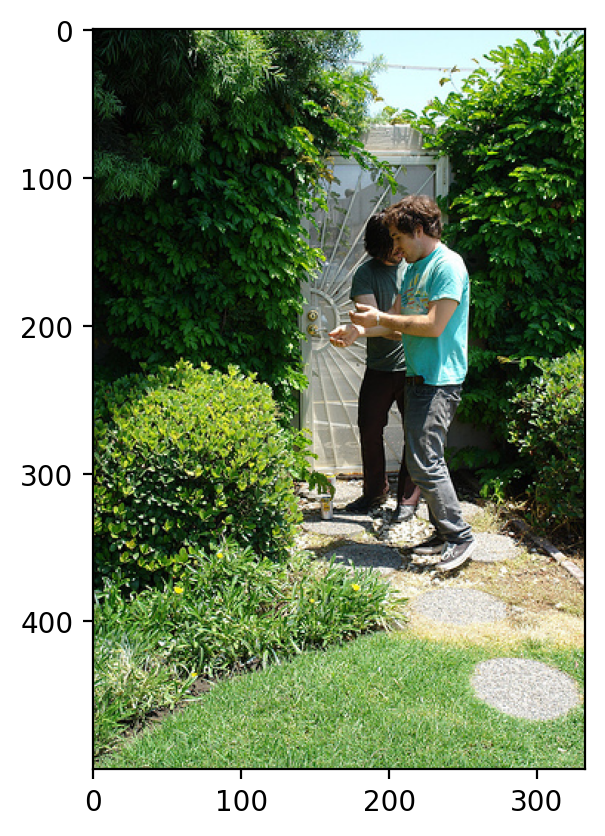

In [7]:
image_file = df_train["image"].iloc[0]
caption = df_train["caption"].iloc[0]

image = cv2.imread(f"{config.image_dir}/{image_file}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(caption)
plt.imshow(image)
plt.show()

For our dataset, we'll keep it minimalistic and use:

- Torch's Dataset which keeps data in memory as opposed to huggingface's dataset.
- Perform resize and normalize for image augmentation via [albumentations](https://albumentations.ai/docs/getting_started/image_augmentation/).
- Create our train and val DataLoader from our dataframe.

In [8]:
class CLIPDataset(Dataset):
    """
    image_filenames and cpations must have the same length; so, if there are
    multiple captions for each image, the image_filenames must have repetitive
    file names 
    """

    def __init__(self, image_dir, image_filenames, image_size, captions, tokenizer, text_max_length):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.captions = captions
        self.tokenizer = tokenizer
        self.text_max_length = text_max_length
        self.transforms = self.get_transforms(image_size)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.captions[idx],
            truncation=True,
            max_length=self.text_max_length
        )
        image = cv2.imread(f"{self.image_dir}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)["image"]
        encoded["image"] = image
        return encoded

    def __len__(self):
        return len(self.captions)

    def get_transforms(self, image_size):
        return A.Compose(
            [
                A.Resize(config.image_size, config.image_size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True)
            ]
        )

In [9]:
class DataCollatorForClip:
    """Data collator that will dynamically pad the text and image inputs received."""

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        text_feature = {
            "input_ids": [feature["input_ids"] for feature in features],
            "attention_mask": [feature["attention_mask"] for feature in features]
        }
        batch = self.tokenizer.pad(
            text_feature,
            padding=True,
            return_tensors="pt"
        )
        # convert to channel first
        image_feature = [torch.FloatTensor(feature["image"]) for feature in features]
        image = torch.stack(image_feature).permute(0, 3, 1, 2)
        batch["image"] = image
        return batch

In [10]:
def build_data_loaders(config, df, tokenizer, mode):
    dataset = CLIPDataset(
        config.image_dir,
        list(df["image"].values),
        config.image_size,
        list(df["caption"].values),
        tokenizer,
        config.text_max_length,
    )
    data_collator = DataCollatorForClip(tokenizer)
    data_loader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        collate_fn=data_collator,
        pin_memory=True,
        shuffle=True if mode == "train" else False
    )
    return data_loader

In [11]:
tokenizer = AutoTokenizer.from_pretrained(config.text_encoder_model)
data_loader_train = build_data_loaders(config, df_train, tokenizer, mode="train")
data_loader_val = build_data_loaders(config, df_val, tokenizer, mode="val")

In [12]:
batch = next(iter(data_loader_train))
print("text shape: ", batch["input_ids"].shape)
print("image shape: ", batch["image"].shape)

text shape:  torch.Size([64, 31])
image shape:  torch.Size([64, 3, 224, 224])


## Model

CLIP model comprises of three components [[6]](https://openai.com/blog/clip/): image encoder, text encoder and projection head (absorbed inside encoder block in the diagram).

<img src="imgs/clip_contrastive_pretraining.png" width="50%" height="50%">

During training we'll need to feed our batches of text and images through its own respective encoder. Given a batch of $n$ text, image pairs, $\text{text}_i, \text{image}_i$, CLIP is trained to predict which of the $n × n$ possible (image, text) pairings across a batch actually occurred. To do this, CLIP learns a multi-modal embedding space by jointly training an image encoder and text encoder to maximize the $N$ real image and text embedding pairs' (cosine) similarity in a given batch while minimizing cosine similarity of $n^2 − n$ incorrect image and text embedding pairings. This is commonly referred to as InfoNCE loss.

\begin{align}
L = -\frac{1}{n} \sum^n_{i=1} \frac{exp(sim(\text{text}_i, \text{image}_i))}{\sum_j exp(sim(\text{text}_i, \text{image}_j))}
\end{align}

Where $sim$ is a similarity function such as cosine similarity or dot product that aims to pull . This can then be treated as a mult-class classification task using cross entropy loss, with the difference that number of class here will be the number of negatives within that batch instead of the distinct number of classes that we wish to predict in a multi-class classification problem.

Here we will be implementing the clip components ourselves, but huggingface `transformers` also has a [clip implementation](https://huggingface.co/docs/transformers/main/en/model_doc/clip) which we can use for reference.

- We load image encoder from `timm` and text encoder from huggingface `transformers`. 
- Projection head is responsible for taking both image and text encodings and embedding them into the same dimensional space.

Feel free to experiment with different image or text encoders, as well as projection head.

In [13]:
class ProjectionHead(nn.Module):

    def __init__(
        self,
        embedding_dim,
        projection_dim,
        dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [14]:
class ImageEncoder(nn.Module):

    def __init__(
        self, model_name, pretrained, trainable, embedding_dim, projection_dim, dropout
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        
        for p in self.model.parameters():
            p.requires_grad = trainable

        self.projection = ProjectionHead(embedding_dim, projection_dim, dropout)

    def forward(self, img_arr):
        image_feature = self.model(img_arr)
        image_embedding = self.projection(image_feature)
        return image_embedding

In [15]:
image_encoder = ImageEncoder(
    model_name=config.image_encoder_model,
    pretrained=config.pretrained,
    trainable=config.trainable,
    embedding_dim=config.image_embedding_dim,
    projection_dim=config.projection_dim,
    dropout=config.dropout
)

In [16]:
image_embedding = image_encoder(batch["image"])
image_embedding.shape

torch.Size([64, 256])

In [17]:
class TextEncoder(nn.Module):

    def __init__(
        self, model_name, pretrained, trainable, embedding_dim, projection_dim, dropout
    ):
        super().__init__()
        if pretrained:
            self.model = AutoModel.from_pretrained(model_name)
        else:
            config = AutoConfig.from_pretrained(model_name)
            self.model = AutoModel.from_config(config)

        for p in self.model.parameters():
            p.requires_grad = trainable

        self.projection = ProjectionHead(embedding_dim, projection_dim, dropout)

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # we are using CLS token hidden representation as sentence's embedding
        text_feature = output.last_hidden_state[:, 0, :]
        text_embedding = self.projection(text_feature)
        return text_embedding

In [18]:
text_encoder = TextEncoder(
    model_name=config.text_encoder_model,
    pretrained=config.pretrained,
    trainable=config.trainable,
    embedding_dim=config.text_embedding_dim,
    projection_dim=config.projection_dim,
    dropout=config.dropout
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
text_embedding = text_encoder(batch["input_ids"], batch["attention_mask"])
text_embedding.shape

torch.Size([64, 256])

Upon confirming both our image and text encoder returns an embedding of the same shape, we can now assemble the clip model.

In [20]:
class ClipModel(pl.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.image_encoder = ImageEncoder(
            model_name=config.image_encoder_model,
            pretrained=config.pretrained,
            trainable=config.trainable,
            embedding_dim=config.image_embedding_dim,
            projection_dim=config.projection_dim,
            dropout=config.dropout
        )
        self.text_encoder = TextEncoder(
            model_name=config.text_encoder_model,
            pretrained=config.pretrained,
            trainable=config.trainable,
            embedding_dim=config.text_embedding_dim,
            projection_dim=config.projection_dim,
            dropout=config.dropout
        )

        self.save_hyperparameters()

    def forward(self, batch):
        # Getting text and image embedding (with same dimension)
        text_embedding = self.text_encoder(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        image_embedding = self.image_encoder(batch["image"])
        return text_embedding, image_embedding

    def _compute_loss(self, text_embedding, image_embedding):
        # @ is equivalent to torch.mm, calculating similarity between text
        # and image embedding
        logits = (text_embedding @ image_embedding.T) / self.config.temperature
        targets = torch.arange(logits.shape[0], device=config.device, dtype=torch.long)
        text_loss = F.cross_entropy(logits, targets, reduction="none")
        image_loss = F.cross_entropy(logits.T, targets, reduction="none")
        loss = (image_loss + text_loss) / 2.0
        return loss.mean()

    def training_step(self, batch, batch_idx):
        text_embedding, image_embedding = self.forward(batch)
        loss = self._compute_loss(text_embedding, image_embedding)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        text_embedding, image_embedding = self.forward(batch)
        loss = self._compute_loss(text_embedding, image_embedding)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.config.lr,
            weight_decay=self.config.weight_decay
        )
        return optimizer

In [21]:
clip = ClipModel(config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
if not config.model_checkpoint:
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=-1,
        max_epochs=config.epochs,
        precision=16,
        # note, we purpose-fully disabled the progress bar to prevent flooding our notebook's console
        # in normal settings, we can/should definitely turn it on
        enable_progress_bar=False,
        log_every_n_steps=500,
    )
    t1_start = perf_counter()
    trainer.fit(clip, data_loader_train, data_loader_val)
    t1_stop = perf_counter()
    print("Training elapsed time:", t1_stop - t1_start)
    clip = clip.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
else:
    clip = clip.load_from_checkpoint(config.model_checkpoint)

# set to evaluation after training, we'll be doing inferencing in the next section
clip.to(config.device)
clip.eval()

ModelSummary(clip, max_depth=1)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 24.1 M
1 | text_encoder  | TextEncoder  | 66.6 M
-----------------------------------------------
90.7 M    Trainable params
0         Non-trainable params
90.7 M    Total params
181.450   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=4` reached.


Training elapsed time: 1812.1229990369757


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 24.1 M
1 | text_encoder  | TextEncoder  | 66.6 M
-----------------------------------------------
90.7 M    Trainable params
0         Non-trainable params
90.7 M    Total params
362.900   Total estimated model params size (MB)

## Inference

For inferencing, what we'll do is giving the model a piece of text and have it retrieve the most relevant images from an unseen validation (or test) set.

In [23]:
def get_image_embeddings(image_encoder, data_loader):
    image_embeddings = []
    with torch.no_grad():
        for batch in data_loader:
            image_embedding = image_encoder(batch["image"].to(config.device))
            image_embeddings.append(image_embedding)

    return torch.cat(image_embeddings)

In [24]:
# generate embeddings for all distinct images in our validation dataset
df_test = df_val[df_val["caption_number"] == "0"]
data_loader_test = build_data_loaders(config, df_test, tokenizer, mode="test")

t1_start = perf_counter()
image_embeddings = get_image_embeddings(clip.image_encoder, data_loader_test)
t1_stop = perf_counter()
print("Image embedding prediction elapsed time:", t1_stop - t1_start)

Image embedding prediction elapsed time: 9.394317086029332


In [25]:
def find_matches(model, image_embeddings, query, image_filenames, n):
    """
    This is a crude way of computing top-k cosine similarity between
    input query and all of our image embeddings.
    """
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_embeddings = model.text_encoder(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches = [image_filenames[idx] for idx in indices]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{config.image_dir}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

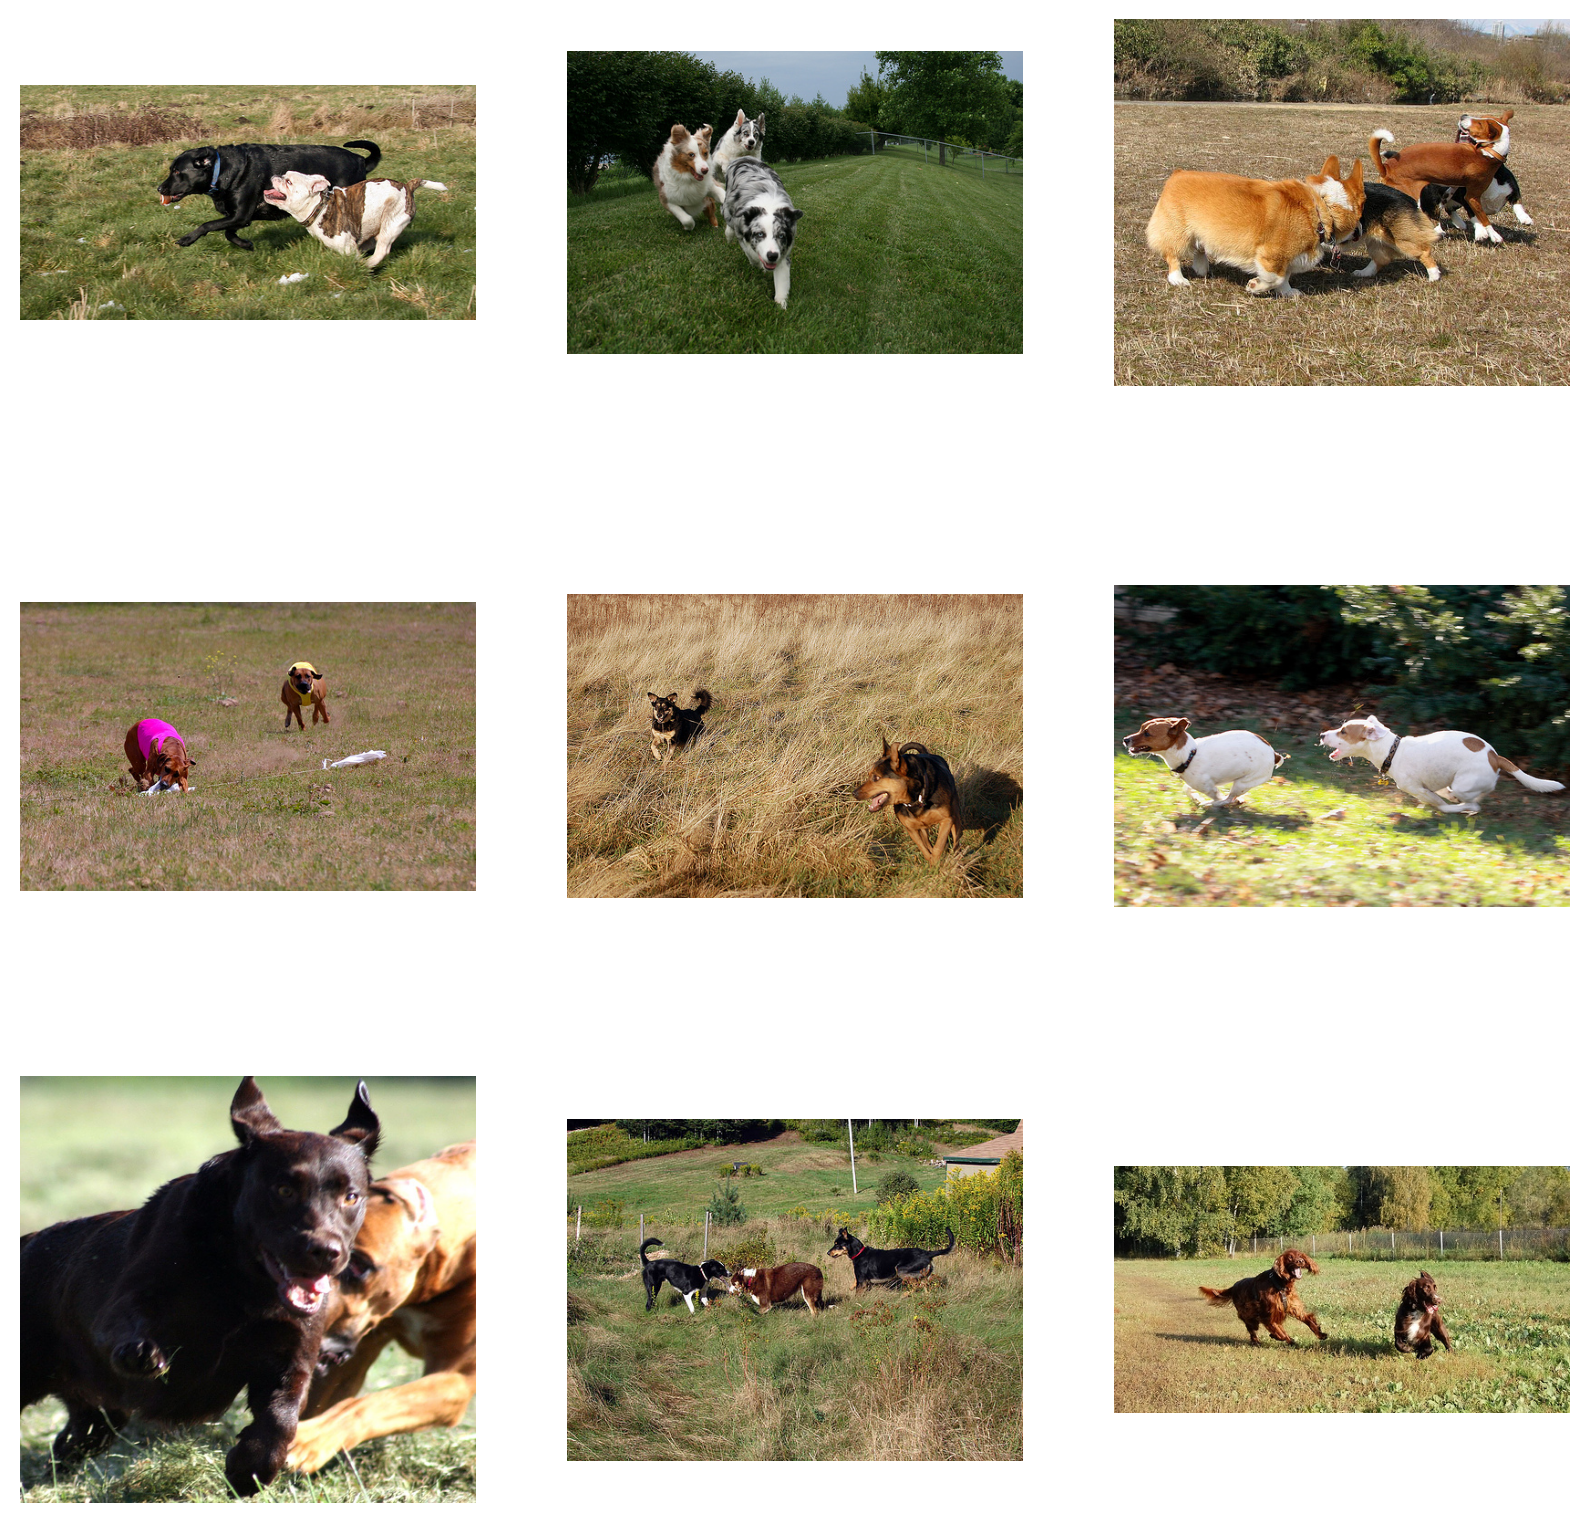

In [26]:
find_matches(
    clip, 
    image_embeddings,
    query="dogs on the grass",
    image_filenames=df_test['image'].values,
    n=9
)

Quick qualitative analysis shows our model shows our model is performing quite well on image retrieval task, of course, we would like to perform quantitative evaluation on downstream benchmark tasks and let actual numbers speak for itself. One common setup for doing this called linear probing, where we add a linear classifier on top of our pre-trained embedding and fine-tune it on a downstream supervised learning task while keeping the pre-trained embedding frozen during training. Will leave this for future posts.

## Notes

In this document we went through how we can use PyTorch Lightning to implement CLIP like models.

Some of other key learnings from the work includes:

- Data: One of key ingredients of pre-training is large scale data. CLIP collected a new dataset comprised of 400 million image text pairs from public internet.
- Objective: Choosing proxy task that is training efficient was to key to scaling learning image representations via natural language supervision. As illustrated in this document, CLIP chose a two tower contrastive approach of predicting which text as a whole is paired with which image, instead of predictive objective such as predicting exact words of that caption or generative models.
- Encoder: We can always experiment with different encoder architectures, authors reported a 3x gain in compute efficiency by adopting vision transformer over a standard ResNet for the image encoder, and found that the model is less sensitive to the text encoder's capacity. They also reported using a higher 336 pixel resolution for images. 
- Training recipe:
    - Important thing to note is that their contrastive loss uses a very large minibatch size of 32,768, and the calculation of embedding similarities are sharded with individual GPUs.
    - Their largest Vision Transformer took 12 days on 256 V100 GPUs.
    - They train CLIP model completely from scratch without initializing image or text encoder with pre-trained weights.
- Zero shot capabilties: Given CLIP leverages natural langauge supervision, this enables far stronger generalization and zero shot capabilities. e.g. Given a task of classifying photos of objects, we can check each image whether CLIP predicts which of the caption "a photo of a dog" or "a photo of a car", etc. is more likely to be paired with it (depicted in the diagram below). We can imagine swapping out the dog and car part with any other class in our prompt making this applicable to potentially arbitrary classification tasks. Caveat: this may require trail and error "prompt engineering" to work well, and still has poor generalization to images not covered in its pre-training dataset.

<img src="imgs/clip_zero_shot.png" width="60%" height="60%">

# Reference

- [[1]](https://github.com/moein-shariatnia/OpenAI-CLIP) Github: Simple CLIP
- [[2]](https://github.com/mlfoundations/open_clip) Github : mlfoundations open_clip
- [[3]](https://github.com/openai/CLIP) Github : openai CLIP
- [[4]](https://wandb.ai/manan-goel/coco-clip/reports/Implementing-CLIP-with-PyTorch-Lightning--VmlldzoyMzg4Njk1) Implementing CLIP with PyTorch Lightning
- [[5]](https://blog.roboflow.com/openai-clip/) OpenAI's CLIP is the most important advancement in computer vision this year
- [[6]](https://openai.com/blog/clip/) Blog: CLIP: Connecting Text and Images
- [[7]](https://arxiv.org/abs/2103.00020) Alec Radford, Jong Wook Kim, et. al - Learning Transferable Visual Models From Natural Language Supervision - 2021